In [1]:
import lightkurve as lk
%matplotlib inline

In [2]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import lightkurve as lk; print("lightkurve", lk.__version__)
import astropy; print("astropy", astropy.__version__)
import numpy as np; print("numpy", np.__version__)

Linux-5.15.0-56-generic-x86_64-with-glibc2.35
Python 3.9.13 (main, Aug 25 2022, 23:26:10) 
[GCC 11.2.0]
lightkurve 2.3.0
astropy 5.1
numpy 1.21.5


# Demonstration
I noticed this issue when using the estimate_cdpp function. The bug occurs when a premade light curve is flattened, then clipped for outliers. An error message relating to array shapes arises.

In [3]:
lc = lk.search_lightcurve('KIC 6922244', author="Kepler", 
                          cadence="long", quarter=4).download()
lc = lc.flatten()
lc = lc.remove_outliers()

ValueError: could not broadcast input array from shape (4116,) into shape ()

If we download a tpf file, turn it into a lightcurve, then flatten it, removing outliers works just fine.

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

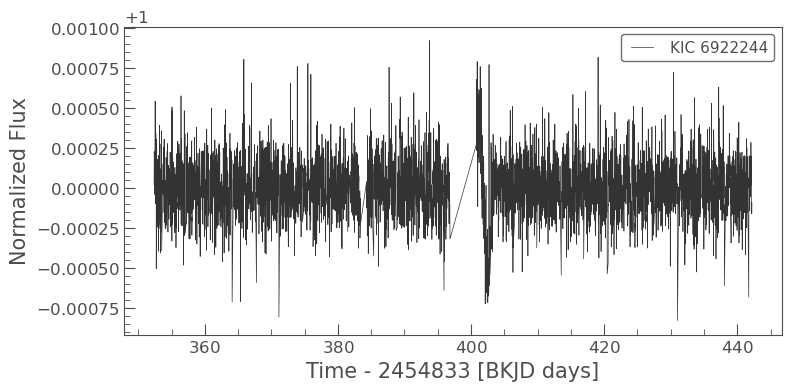

In [4]:
# download tpf, make light curve, then flatten
tpf = lk.search_targetpixelfile('KIC 6922244', author="Kepler", 
                                cadence="long", quarter=4).download()
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc = lc.flatten()
lc = lc.remove_outliers()
lc.plot()

I noticed .remove_outliers() is a wrap of Astropy's sigma_clip function. So I installed older Astropy verions to find where there might be a problem. The issue pops up when Astropy updated from 4.3.1 to 5.0. I couldn't find any difference between the sigma_clip functions in the different Astropy versions, so I'm still not exactly sure where things are breaking. But I was able to find a quick fix by removing astropy units from the remove outlier function.

In [5]:
import numpy as np
import warnings
from lightkurve.utils import running_mean
from astropy.stats.sigma_clipping import sigma_clip

In [6]:
def remove_outliers(self, sigma=5.0, sigma_lower=None, sigma_upper=None, return_mask=False, **kwargs):
    
    # First, we create the outlier mask using AstroPy's sigma_clip function
    with warnings.catch_warnings():  # Ignore warnings due to NaNs or Infs
        warnings.simplefilter("ignore")
        
        outlier_mask = sigma_clip(
            data=self.flux.value, # use unitless array to fix lk bug
            sigma=sigma,
            sigma_lower=sigma_lower,
            sigma_upper=sigma_upper,
            **kwargs,
        ).mask
        
        # Second, we return the masked light curve and optionally the mask itself
        if return_mask:
            return self.copy()[~outlier_mask], outlier_mask
        return self.copy()[~outlier_mask]


<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

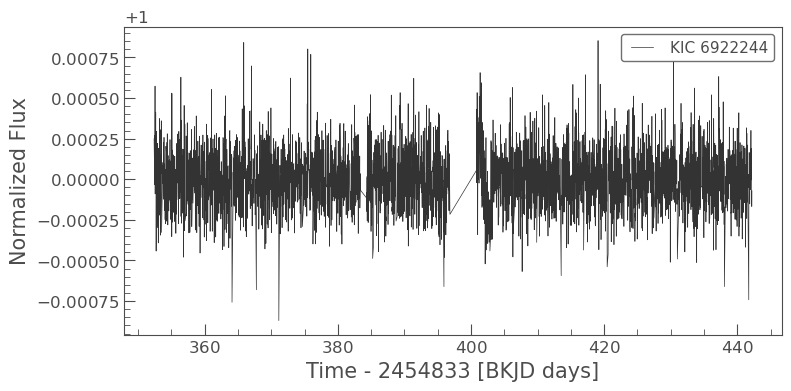

In [7]:
lc = lk.search_lightcurve('KIC 6922244', author="Kepler", cadence="long", quarter=4).download()
lc = lc.flatten()
lc = remove_outliers(lc)
lc.plot()